In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [3]:
EMBEDDING_FILE='F:/BaiduDiskDownload/sgns.zhihu.word'
TRAIN_DATA_FILE='data/trainingset.csv'
TEST_DATA_FILE='data/testa.csv'
VALIDATE_DATE_FILE = 'data/validationset.csv'

In [5]:
train_only = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)
validation = pd.read_csv(VALIDATE_DATE_FILE)

In [6]:
train = pd.concat([train_only, validation],axis=0,ignore_index=True)

In [7]:
sentiments = train.columns.tolist()[2:]

In [8]:
sentiments[:6]

['location_traffic_convenience',
 'location_distance_from_business_district',
 'location_easy_to_find',
 'service_wait_time',
 'service_waiters_attitude',
 'service_parking_convenience']

In [9]:
list_sentences_train = train["content"].values
y = train[sentiments[:6]].values
list_sentences_test = test["content"].values

In [10]:
comments = train['content']

In [56]:
def punctuation_filter(content):
    return content.replace('\"','').replace('，','').replace('。','').replace('【',
    '').replace('】','').replace('\n','').replace('；','').replace('.','').replace('～','')

In [58]:
import jieba

def cut(content):
    return ' '.join(jieba.cut(content))

X_w = list()
import tqdm

for c in tqdm.tqdm(comments):
    X_w.append(punctuation_filter(cut(c)))

100%|█████████████████████████████████████████████████████████████████████████| 120000/120000 [04:46<00:00, 418.20it/s]


In [60]:
comments_t = test['content']

X_t = list()
for c in tqdm.tqdm(comments_t):
    X_t.append(punctuation_filter(cut(c)))

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:37<00:00, 403.96it/s]


In [80]:
max_features=10000

In [81]:
tok=text.Tokenizer(num_words=max_features)
tok.fit_on_texts(X_w + X_t)
X_train=tok.texts_to_sequences(X_w)
X_test=tok.texts_to_sequences(X_t)

In [73]:
comment_lens = [x.count(' ') for x in tqdm.tqdm(X_w)]

100%|██████████████████████████████████████████████████████████████████████| 120000/120000 [00:00<00:00, 350792.08it/s]


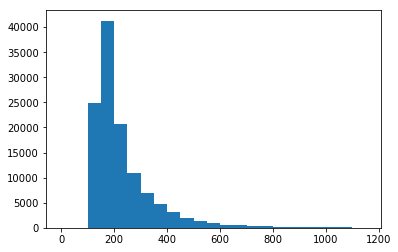

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(comment_lens, bins=np.arange(0,1200,50))
plt.show()

In [78]:
maxlen=400
embed_size=200
cat_count = 6

In [82]:
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [83]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [84]:
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [85]:
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [86]:
from keras.layers import K, Activation
from keras.engine import Layer
from keras.layers import Dense, Input, Embedding, Dropout, Bidirectional, GRU, Flatten, SpatialDropout1D
gru_len = 128
Routings = 5
Num_capsule = 10
Dim_capsule = 16
dropout_p = 0.25
rate_drop_dense = 0.28

def squash(x, axis=-1):
    # s_squared_norm is really small
    # s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    # scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    # return scale * x
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale


# A Capsule Implement with Pure Keras
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


def get_model():
    input1 = Input(shape=(maxlen,))
    embed_layer = Embedding(max_features,
                            embed_size,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=False)(input1)
    embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)

    x = Bidirectional(
        GRU(gru_len, activation='relu', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True))(
        embed_layer)
    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings,
                      share_weights=True)(x)
    # output_capsule = Lambda(lambda x: K.sqrt(K.sum(K.square(x), 2)))(capsule)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
    output = Dense(cat_count, activation='sigmoid')(capsule)
    model = Model(inputs=input1, outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    model.summary()
    return model

In [87]:
model = get_model()

batch_size = 256
epochs = 3
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 300)          3000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 400, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400, 256)          329472    
_________________________________________________________________
capsule_2 (Capsule)          (None, 10, 16)            40960     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 160)               0         
__________

D:\ProgramFiles\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [88]:
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=1, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

Train on 114000 samples, validate on 6000 samples
Epoch 1/1
  9216/114000 [=>............................] - ETA: 3:25:50 - loss: 0.7926 - acc: 0.09 - ETA: 3:08:10 - loss: 0.3341 - acc: 0.07 - ETA: 2:59:13 - loss: -0.0206 - acc: 0.064 - ETA: 2:57:34 - loss: -0.3156 - acc: 0.059 - ETA: 2:56:27 - loss: -0.5743 - acc: 0.054 - ETA: 2:58:03 - loss: -0.7865 - acc: 0.051 - ETA: 2:57:51 - loss: -0.9691 - acc: 0.048 - ETA: 2:57:10 - loss: -1.1232 - acc: 0.047 - ETA: 2:57:05 - loss: -1.2490 - acc: 0.047 - ETA: 2:59:07 - loss: -1.3682 - acc: 0.046 - ETA: 3:00:51 - loss: -1.4572 - acc: 0.046 - ETA: 3:02:01 - loss: -1.5496 - acc: 0.045 - ETA: 3:01:38 - loss: -1.6322 - acc: 0.044 - ETA: 3:01:55 - loss: -1.7101 - acc: 0.043 - ETA: 3:01:35 - loss: -1.7739 - acc: 0.043 - ETA: 3:01:32 - loss: -1.8404 - acc: 0.042 - ETA: 3:02:24 - loss: -1.8946 - acc: 0.041 - ETA: 3:02:39 - loss: -1.9477 - acc: 0.041 - ETA: 3:02:24 - loss: -1.9988 - acc: 0.040 - ETA: 3:02:20 - loss: -2.0543 - acc: 0.039 - ETA: 3:02:39 - 

KeyboardInterrupt: 